HW 2

Этот набор данных содержит информацию о подержанных автомобилях.

- Car_Name - Название автомобиля
- Year - год в котором купил машину предыдущий владелец
- Selling_Price - цена продажи машины сейчас
- Present_Price - предыдущая цена покупки
- Kms_Driven - сколько километров проехала машина
- Fuel_Type - тип используемого топлива
- Seller_Type - тип продавца
- Transmission - тип коробки передач
- Owner - количество владельцев автомобиля до текущего хозяина

Целевой переменной считать - Selling_Price.

1. После загрузки необходимо проанализировать существующие признаки.
2. Определите какие признаки являются числовыми, а какие категориальными (кодом!) Выведите список одних и других.
3. Используйте стратегию валидации Holdout. Постройте линейную регрессию на числовых признаках. Оцените качество работы с помощью метрик MSE и MAE.
4. Проанализируйте важность признаков без библиотеки yellowbrick.
5. Сравните результат вашего анализа с результатов yellowbrick.
6. Добавьте категориальные признаки при помощи метода sklearn.preprocessing.OneHotEncoder. [Документация](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) + [Пример использования](https://www.dmitrymakarov.ru/data-analysis/encoding-10/#10-klass-onehotencoder)
7. Переобучите модель. Также проанализируйте важность признаков, что изменилось? А как изменились метрики?
8. Добавьте регуляризацию (3 типа). Как меняется важность признаков? Как изменяются метрики?
9. Добавьте [Learning Curve](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html) для одной из моделей. [Визуализируйте результат!](https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py)

In [1]:
# Импорты

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.metrics import  mean_absolute_error, mean_squared_error
from sklearn.model_selection import (
    GridSearchCV, LearningCurveDisplay, PredefinedSplit, ShuffleSplit, train_test_split
)
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from yellowbrick.model_selection import FeatureImportances

In [2]:
import warnings
from sklearn.exceptions import FitFailedWarning

# Suppress FitFailedWarning
warnings.filterwarnings("ignore", category=FitFailedWarning)

In [3]:
# Загрузка данных
sharing_url = "https://drive.google.com/file/d/1qeae-8oAfQnULTs838ROpupXLvMNwtiO/view?usp=sharing"
download_url = "https://drive.google.com/uc?id=" + sharing_url.split("/")[-2]

df = pd.read_csv(download_url)

In [4]:
random_state = 45

In [5]:
df.head(2)

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0


## 1.

Данные находятся в разных шкалах, потребуется нормализация:

In [6]:
df.describe()

,Year,Selling_Price,Present_Price,Kms_Driven,Owner
count,301.000000,301.000000,301.000000,301.000000,301.000000
mean,2013.627907,4.661296,7.628472,36947.205980,0.043189
std,2.891554,5.082812,8.644115,38886.883882,0.247915
min,2003.000000,0.100000,0.320000,500.000000,0.000000
25%,2012.000000,0.900000,1.200000,15000.000000,0.000000
50%,2014.000000,3.600000,6.400000,32000.000000,0.000000
75%,2016.000000,6.000000,9.900000,48767.000000,0.000000
max,2018.000000,35.000000,92.600000,500000.000000,3.000000


Пропущенных значений нет ни в одной колонке, удаление или замена (нулями или средними) не требуется.

In [7]:
df.isna().any()

,0
Car_Name,False
Year,False
Selling_Price,False
Present_Price,False
Kms_Driven,False
Fuel_Type,False
Seller_Type,False
Transmission,False
Owner,False


## 2.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


In [9]:
numeric_features = df.select_dtypes(include=["number"]).columns.tolist()
categorical_features = df.select_dtypes(include=["object", "category"]).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

Numeric features: ['Year', 'Selling_Price', 'Present_Price', 'Kms_Driven', 'Owner']
Categorical features: ['Car_Name', 'Fuel_Type', 'Seller_Type', 'Transmission']


## 3.

Разделение на train, val, test

In [10]:
X_temp, X_test, y_temp, y_test = train_test_split(
    df[numeric_features].drop("Selling_Price", axis=1), df["Selling_Price"],
    test_size=0.1, random_state=random_state
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=1/9, random_state=random_state
)

Нормализация

In [11]:
sc = MinMaxScaler()

X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

Подготовка PredefinedSplit

In [12]:
X_combined = np.concatenate((X_train, X_val))
y_combined = np.concatenate((y_train, y_val))

test_fold = np.array([-1] * len(X_train) + [0] * len(X_val))

ps = PredefinedSplit(test_fold)

In [13]:
for i, (train_index, val_index) in enumerate(ps.split()):
    print(f"Fold {i}:")
    print(f"Train: index={train_index}")
    print(f"Val: index={val_index}")

Fold 0:
Train: index=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239]
Val:

Подбор гиперпараметров и обучение

In [14]:
model = LinearRegression()
param_grid = {
    "fit_intercept": [True, False],
    "positive": [True, False]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=ps
)

grid_search.fit(X_combined, y_combined)

print("Best parameters found: ", grid_search.best_params_)
print("Best validation score: ", grid_search.best_score_)

Best parameters found:  {'fit_intercept': True, 'positive': False}
Best validation score:  0.9017439573671798


MSE и MAE на отложенной выборке:

In [15]:
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"MSE: {mse}")
print(f"MAE: {mae}")

MSE: 3.024509728622082
MAE: 1.3389385386549266


## 4.

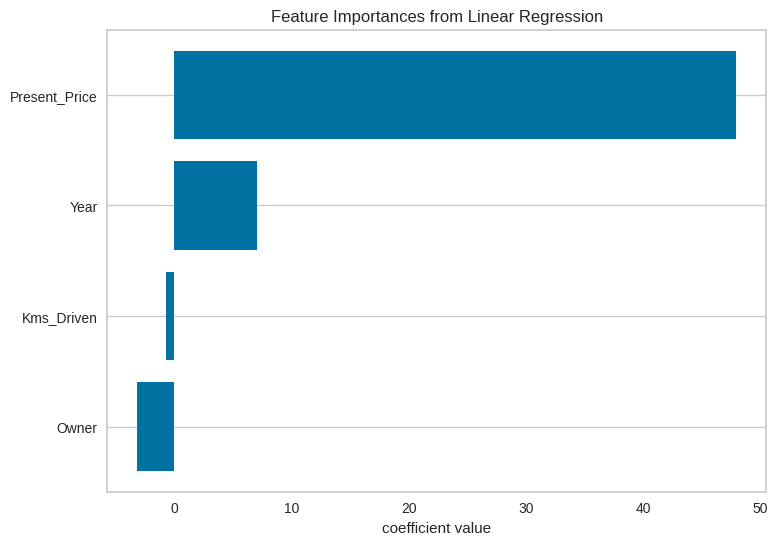

In [16]:
importances = best_model.coef_

importance_df = pd.DataFrame({"Feature": X_temp.columns, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance")

plt.figure(figsize=(8.5, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("coefficient value")
plt.title("Feature Importances from Linear Regression")
plt.grid(axis="x")
plt.show()

Логично, что самый важный признак, положительно скоррелированный с ценой продажи машины - предыдущая цена покупки.

Остальные признаки слабее влияют на результат:

Year - связь с ценой продажи тоже положительная (для машин, которые были приобретены позже, цена продажи выше);

Owner и Kms_Driven - связь отрицательная (больше количество предыдущих владельцев и больше пробег - цена продажи ниже)








## 5.

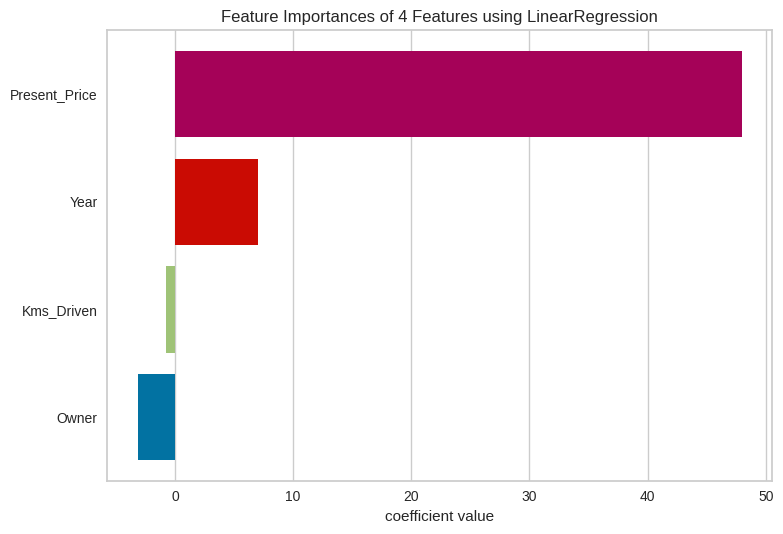

<Axes: title={'center': 'Feature Importances of 4 Features using LinearRegression'}, xlabel='coefficient value'>

In [17]:
viz = FeatureImportances(best_model, labels=X_temp.columns, relative=False)
viz.fit(X_train, y_train)
viz.show()

Результат идентичен тому, который был получен без использования yellowbrick.

## 6.

In [18]:
ohe = OneHotEncoder(sparse_output=False)

df_ohe_only = pd.DataFrame(
    ohe.fit_transform(df[categorical_features]),
    columns=ohe.get_feature_names_out(categorical_features)
)

df_with_ohe = pd.concat([df.drop(categorical_features, axis=1), df_ohe_only], axis=1)

In [19]:
df_with_ohe

,Year,Selling_Price,Present_Price,Kms_Driven,Owner,Car_Name_800,Car_Name_Activa 3g,Car_Name_Activa 4g,Car_Name_Bajaj ct 100,Car_Name_Bajaj Avenger 150,...,Car_Name_vitara brezza,Car_Name_wagon r,Car_Name_xcent,Fuel_Type_CNG,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Dealer,Seller_Type_Individual,Transmission_Automatic,Transmission_Manual
0,2014,3.35,5.59,27000,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
1,2013,4.75,9.54,43000,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,2017,7.25,9.85,6900,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
3,2011,2.85,4.15,5200,0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
4,2014,4.60,6.87,42450,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,2016,9.50,11.60,33988,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
297,2015,4.00,5.90,60000,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
298,2009,3.35,11.00,87934,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
299,2017,11.50,12.50,9000,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


## 7.

In [20]:
X_temp, X_test, y_temp, y_test = train_test_split(
    df_with_ohe.drop("Selling_Price", axis=1), df_with_ohe["Selling_Price"],
    test_size=0.1, random_state=random_state
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=1/9, random_state=random_state
)

In [21]:
sc = MinMaxScaler()

X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

In [22]:
X_combined = np.concatenate((X_train, X_val))
y_combined = np.concatenate((y_train, y_val))

test_fold = np.array([-1] * len(X_train) + [0] * len(X_val))

ps = PredefinedSplit(test_fold)

In [23]:
model = LinearRegression()
param_grid = {
    "fit_intercept": [True, False],
    "positive": [True, False]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=ps,
)

grid_search.fit(X_combined, y_combined)

print("Best parameters found: ", grid_search.best_params_)
print("Best validation score: ", grid_search.best_score_)

Best parameters found:  {'fit_intercept': False, 'positive': False}
Best validation score:  0.9411111450997064


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [       nan 0.94104344 0.92017995 0.94111115]
  warnings.warn(


In [24]:
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"MSE: {mse}")
print(f"MAE: {mae}")

MSE: 2.875938108286856
MAE: 1.0738547233893974


Качество улучшилось: MSE и MAE уменьшились.

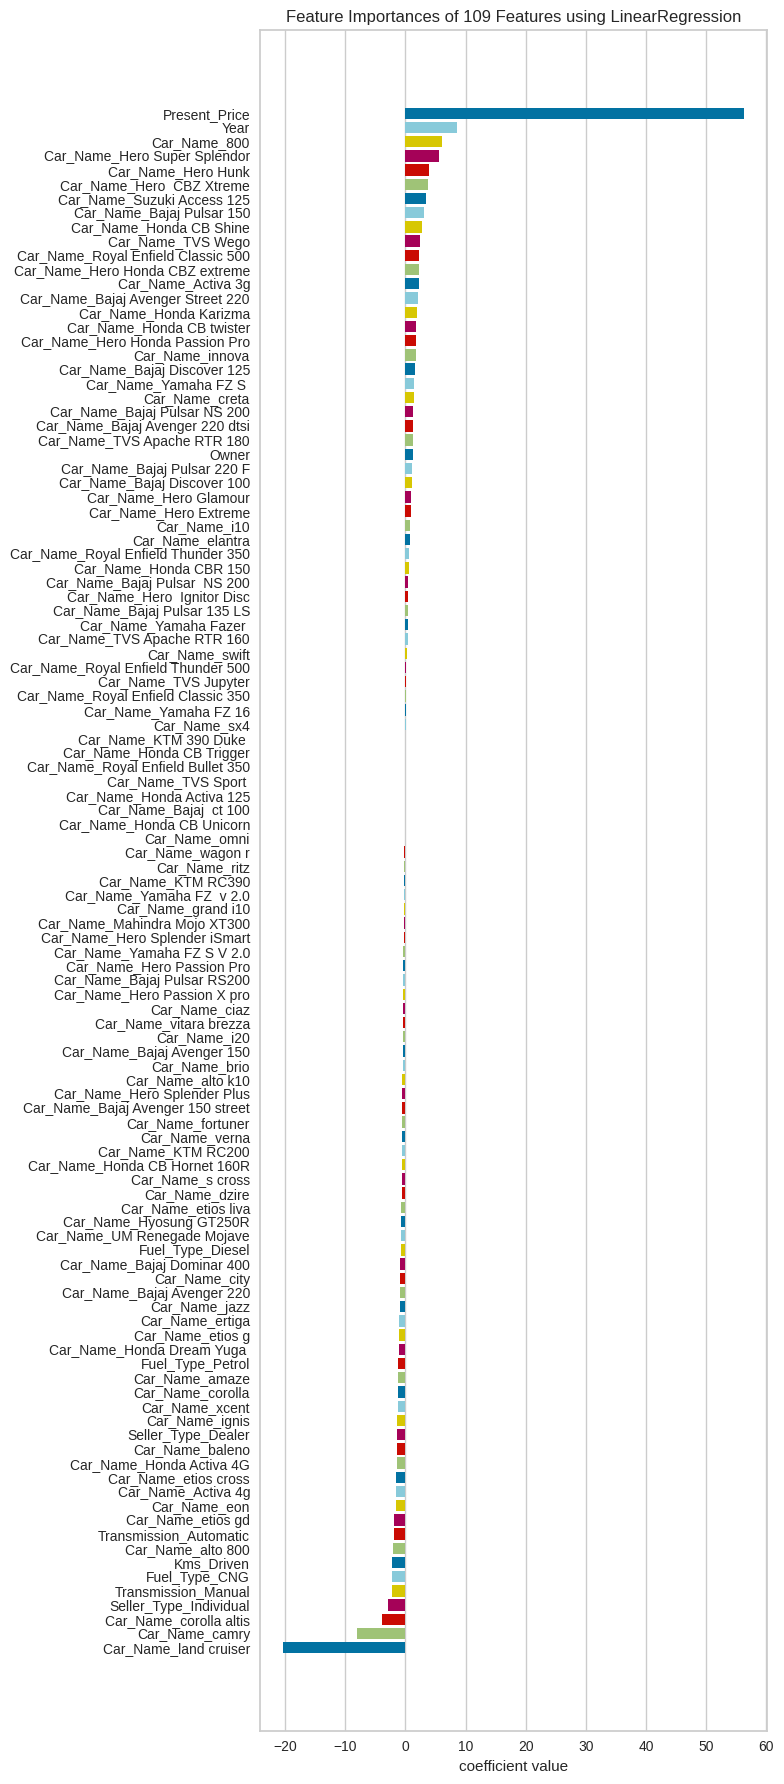

<Axes: title={'center': 'Feature Importances of 109 Features using LinearRegression'}, xlabel='coefficient value'>

In [25]:
viz = FeatureImportances(best_model, labels=X_temp.columns, relative=False, size=(800, 1800))
viz.fit(X_train, y_train)
viz.show()

Цена покупки - по-прежнему самый важный положительно скоррелированный признак. У года (Year) связь с target сильнее, чем у всех остальных положительно скоррелированных признаков, среди которых только конкретные марки автомобилей (и признак Owner, который теперь имеет положительную, а не отрицательную связь с target).

Среди признаков, имеющих отрицательную связь с target - другая половина марок автомобилей (самые информативные - Camry и Land Cruiser), все три типа топлива (самый информативный - газ), оба типа коробки передач (ручная "хуже", чем автоматическая), оба типа продавцов (физическое лицо - Individual "хуже", чем компания - Dealer). Пробег, который изначально был числовым признаком, остался среди отрицательно скоррелированных с target признаков.

## 8.

### Lasso

In [26]:
model = Lasso()
param_grid = {
    "fit_intercept": [True, False],
    "positive": [True, False],
    "alpha": np.arange(0.01, 1.0, 0.01)
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=ps,
)

grid_search.fit(X_combined, y_combined)

print("Best parameters found: ", grid_search.best_params_)
print("Best validation score: ", grid_search.best_score_)

Best parameters found:  {'alpha': 0.01, 'fit_intercept': False, 'positive': False}
Best validation score:  0.9513348716085759


In [27]:
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"MSE: {mse}")
print(f"MAE: {mae}")

MSE: 3.288819445525443
MAE: 1.2348250955291578


MSE стал хуже, чем у обоих предыдущих вариантов. MAE хуже, чем у модели с one-hot encoding'ом, но лучше, чем у модели без категориальных признаков.

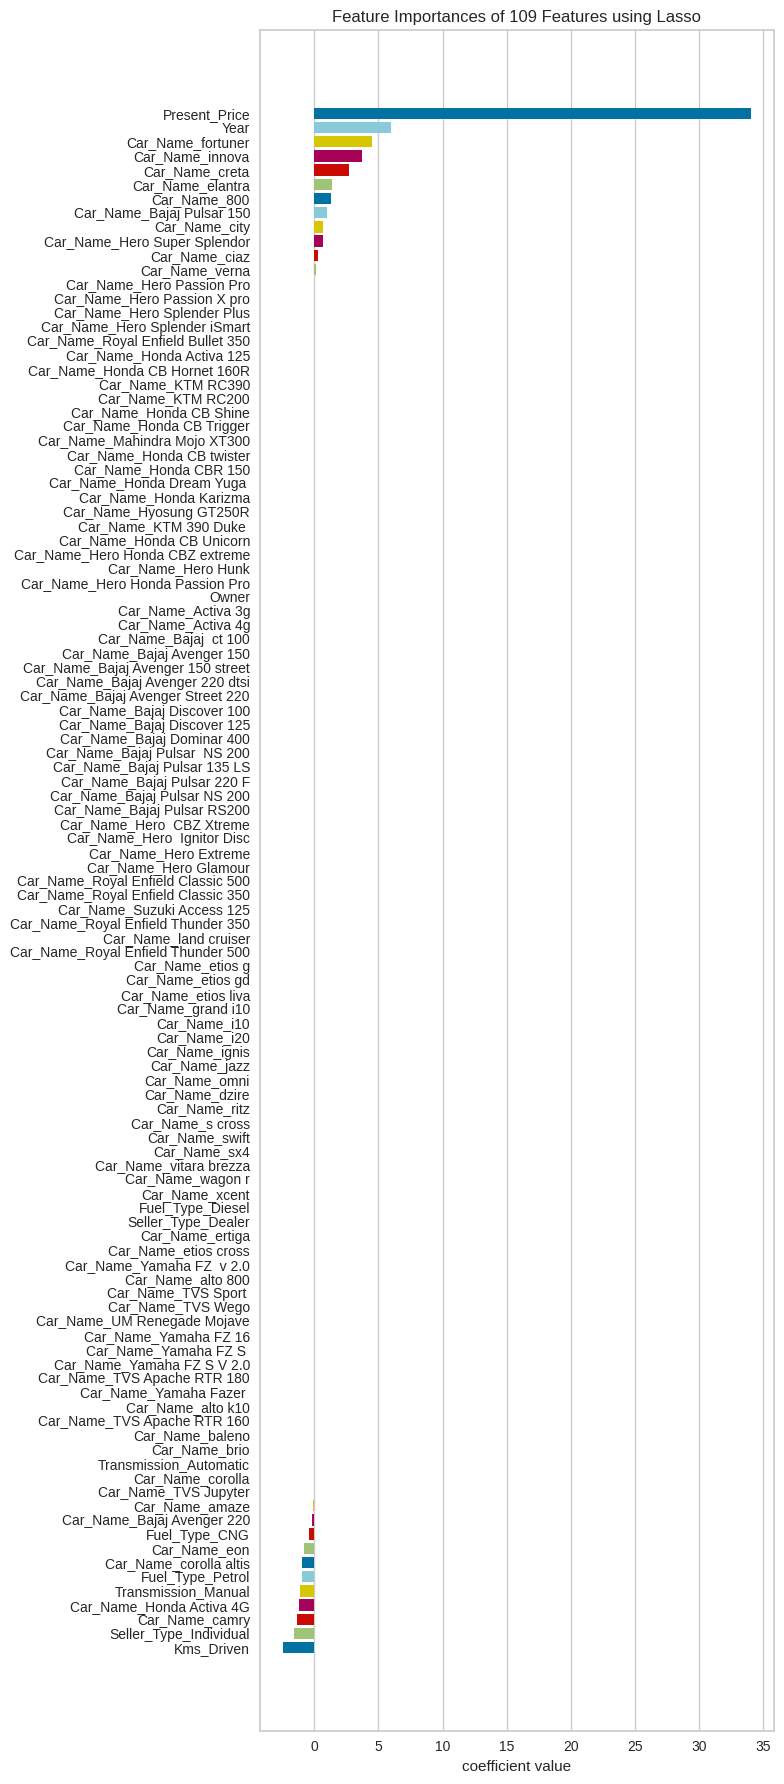

<Axes: title={'center': 'Feature Importances of 109 Features using Lasso'}, xlabel='coefficient value'>

In [28]:
viz = FeatureImportances(best_model, labels=X_temp.columns, relative=False, size=(800, 1800))
viz.fit(X_train, y_train)
viz.show()

Present Price по-прежнему самые информативные признаки среди положительно скоррелированных. У наименее информативных признаков коэффициенты приравнялись к нулю (по определению Lasso-регуляризации). Отрицательные коэффициенты остались у двух самых информативных из трех типов топлива (газ и бензин), одного из двух типов коробки передач (ручная) и одного из двух типов продавцов (физлицо). Самый большой по модулю коэффициент среди отрицательных теперь не у конкретной марки автомобиля, а у пробега.

### Ridge

In [29]:
model = Ridge()
param_grid = {
    "fit_intercept": [True, False],
    "positive": [True, False],
    "alpha": np.arange(0.01, 1.0, 0.01)
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=ps,
)

grid_search.fit(X_combined, y_combined)

print("Best parameters found: ", grid_search.best_params_)
print("Best validation score: ", grid_search.best_score_)

Best parameters found:  {'alpha': 0.33, 'fit_intercept': True, 'positive': True}
Best validation score:  0.9451070363560622


In [30]:
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"MSE: {mse}")
print(f"MAE: {mae}")

MSE: 3.227704644798028
MAE: 1.164149274678467


Оба значения лосса лучше, чем у модели с Lasso. Но MSE все еще хуже, чем у обоих вариантов без регуляризации, и MAE все еще хуже, чем у второго варианта (с категориальными признаками).

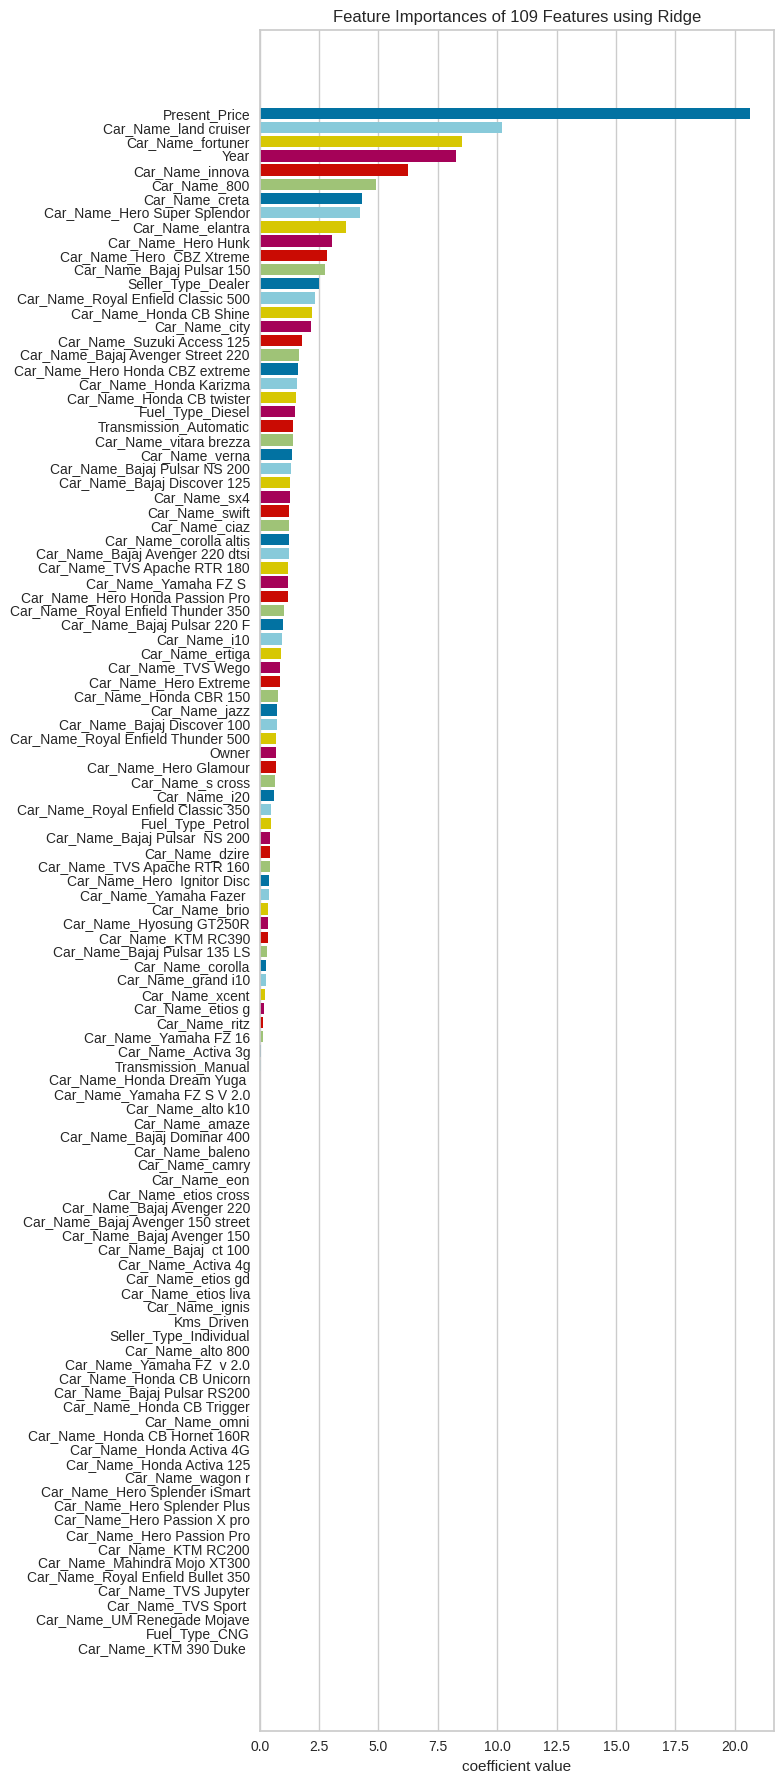

<Axes: title={'center': 'Feature Importances of 109 Features using Ridge'}, xlabel='coefficient value'>

In [31]:
viz = FeatureImportances(best_model, labels=X_temp.columns, relative=False, size=(800, 1800))
viz.fit(X_train, y_train)
viz.show()

Выбранный гиперпараметр ```'positive': True``` обозначает запрет на отрицательные коэффициенты: остались только положительные. Land Cruiser из самого "плохого" признака в линейной регрессии без регуляризации оказался в топ-2 положительных. Present Price по-прежнему самый информативный признак, а Year передвинулся из топ-2 в топ-4.



### ElasticNet

In [32]:
model = ElasticNet()
param_grid = {
    "fit_intercept": [True, False],
    "positive": [True, False],
    "alpha": np.arange(0.01, 1.0, 0.01),
    "l1_ratio": np.arange(0.1, 1.0, 0.1)
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=ps,
)

grid_search.fit(X_combined, y_combined)

print("Best parameters found: ", grid_search.best_params_)
print("Best validation score: ", grid_search.best_score_)

Best parameters found:  {'alpha': 0.01, 'fit_intercept': False, 'l1_ratio': 0.9, 'positive': False}
Best validation score:  0.943984182266016


In [33]:
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"MSE: {mse}")
print(f"MAE: {mae}")

MSE: 3.437357271604523
MAE: 1.2226971148654018


Самое плохое из всех значение MSE; MAE хуже, чем у Ridge, но лучше, чем у Lasso.

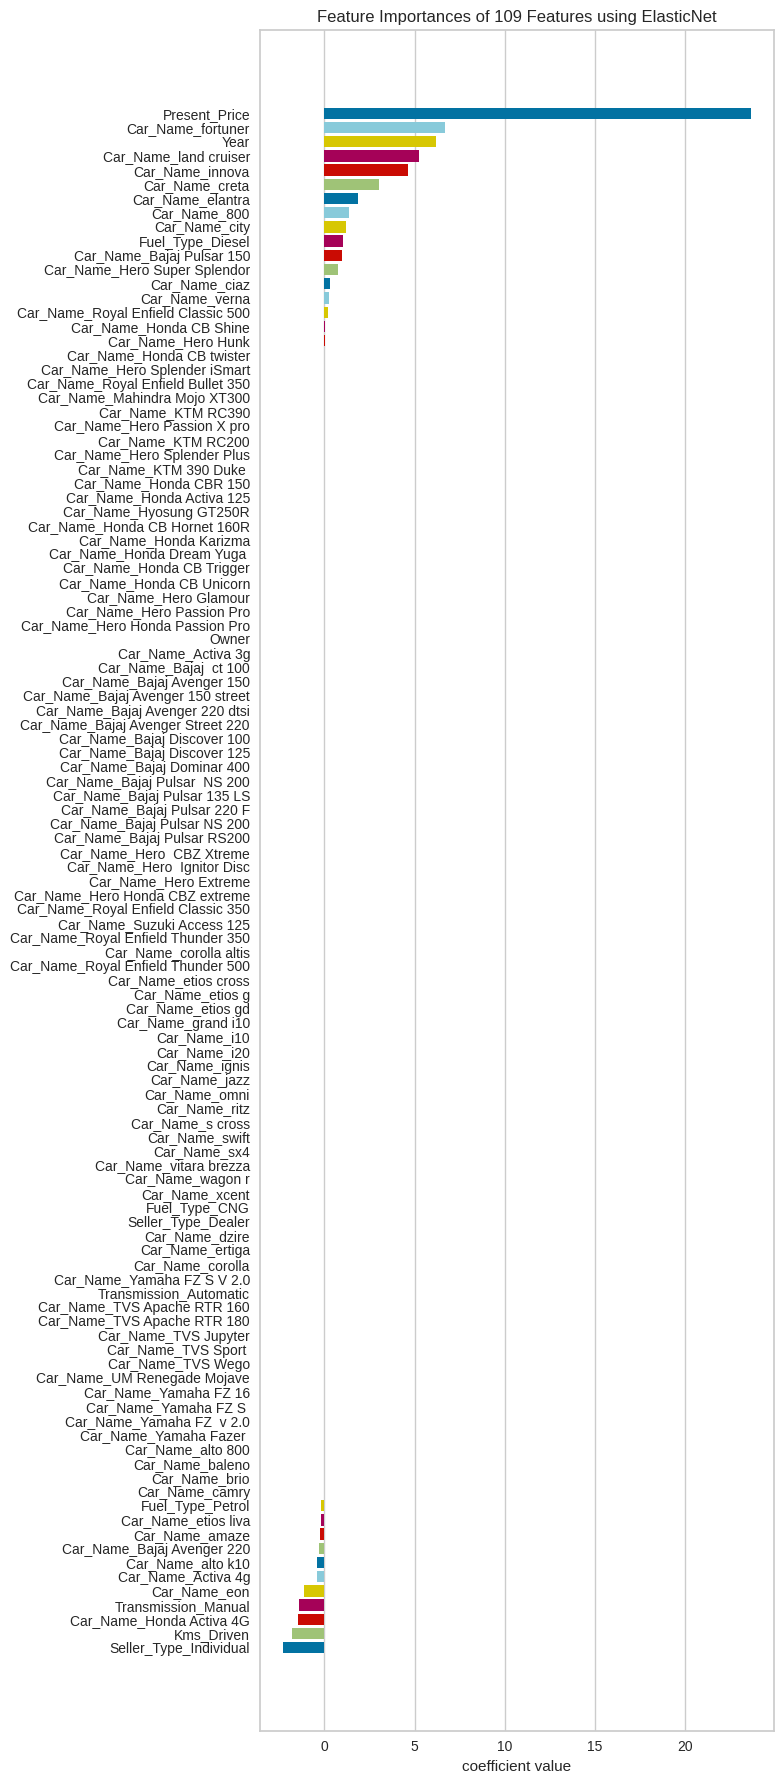

<Axes: title={'center': 'Feature Importances of 109 Features using ElasticNet'}, xlabel='coefficient value'>

In [34]:
viz = FeatureImportances(best_model, labels=X_temp.columns, relative=False, size=(800, 1800))
viz.fit(X_train, y_train)
viz.show()

Present Price по-прежнему самый информативный параметр. В топ-7 самых информативных параметров попали те же, что у Ridge. Наименее информативные коэффициенты приравнялись к нулю, как в Lasso (т.к. ElasticNet - комбинация Lasso и Ridge). Самым важным отрицательно скоррелированным признаком стал тип продавца - физлицо. Пробег оказался на предпоследнем месте (у модели с Lasso был последним).

## 8. Learning Curve для ElasticNet

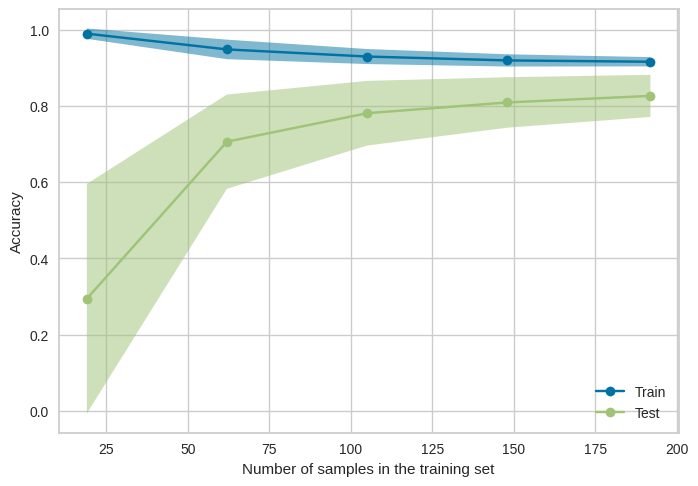

In [35]:
common_params = {
    "X": X_train,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

LearningCurveDisplay.from_estimator(best_model, **common_params)